In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# Step 1: Load the Excel file
folder_path = "Data\InputData"

all_data = []
for filename in os.listdir(folder_path):
    print(f"Processing file: {filename}")  # Debugging line to check file processing
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            print(f"Loaded {filename} with shape {df.shape}")  # Debugging line to check loaded data
            all_data.append(df)
        except Exception as e:
            print(f"Error loading {filename}: {e}")  #Good to print errors to console

if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)  


Processing file: April_Perf.csv
Loaded April_Perf.csv with shape (5208585, 9)
Processing file: Jul_Perf.csv
Loaded Jul_Perf.csv with shape (5722800, 9)
Processing file: Jun-Perf.csv
Loaded Jun-Perf.csv with shape (5706416, 9)
Processing file: May_Perf.csv
Loaded May_Perf.csv with shape (5505692, 9)


In [3]:
combined_df.info()  # Display the first few rows of the combined DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22143493 entries, 0 to 22143492
Data columns (total 9 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   elevatorunitId        int64 
 1   elevatorunitnumber    object
 2   CpibUuid              object
 3   countryname           object
 4   DESCRIPTION           object
 5   ItemFieldId           object
 6   PerformanceStartDate  object
 7   PerformanceEndDate    object
 8   Readvalue             int64 
dtypes: int64(2), object(7)
memory usage: 1.5+ GB


In [4]:
combined_df['Date'] = pd.to_datetime(combined_df['PerformanceStartDate']).dt.date
pivot_df = combined_df.pivot_table(
    index=['elevatorunitId', 'elevatorunitnumber', 'Date'],
    columns='ItemFieldId',
    values='Readvalue',
    aggfunc='sum'
).reset_index()

pivot_df.columns = pivot_df.columns.str.strip().str.replace(' ', '_')
pivot_df.head(2)

pivot_df.info()  # Display the first few rows of the pivoted DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181421 entries, 0 to 1181420
Data columns (total 27 columns):
 #   Column                                Non-Null Count    Dtype  
---  ------                                --------------    -----  
 0   elevatorunitId                        1181421 non-null  int64  
 1   elevatorunitnumber                    1181421 non-null  object 
 2   Date                                  1181421 non-null  object 
 3   door_operations                       804022 non-null   float64
 4   door_reversals                        746088 non-null   float64
 5   front_door_cycles                     648248 non-null   float64
 6   front_door_reversals                  484717 non-null   float64
 7   inop11_levelling_errors               21546 non-null    float64
 8   inop2_hoistway_door_lock_failures     18465 non-null    float64
 9   inop3_elevator_start_delayed          7128 non-null     float64
 10  inop4_car_door_open_command_failures  112539 non-null 

In [ ]:
# output_path = 'Data/TestData/feature_added_eng_data.csv'  # Change path as needed
# pivot_df.to_csv(output_path, index=True)

In [5]:
pivot_df['total_door_operations'] = pivot_df[['door_operations', 'front_door_cycles', 'rear_door_cycles']].sum(axis=1)
pivot_df['total_door_reversals'] = pivot_df[['door_reversals', 'front_door_reversals', 'rear_door_reversals']].sum(axis=1)    
pivot_df['door_failure_events'] = pivot_df[['inop4_car_door_open_command_failures', 'inop5_door_open_failures']].sum(axis=1)
pivot_df['hoistway_faults'] = pivot_df['inop2_hoistway_door_lock_failures']
pivot_df['safety_chain_issues'] = pivot_df[['inop7_safety_chain_failures_running', 'inop8_safety_chain_failures_idle']].sum(axis=1)
pivot_df['levelling_total_errors'] = pivot_df[['inop11_levelling_errors', 'levelling_errors', 'number_of_non_level_landings']].sum(axis=1)
pivot_df['startup_delays'] = pivot_df['inop3_elevator_start_delayed']
pivot_df['average_run_time'] = pivot_df[['one_floor_run_time', 'run_time_releveling', 'run_time_rescue']].mean(axis=1)
pivot_df['total_run_starts'] = pivot_df[['run_starts_ero', 'run_starts_inspection', 'run_starts_releveling', 'run_starts_rescue']].sum(axis=1)
pivot_df['total_door_cycles'] = pivot_df['total_door_cycles']

In [6]:
# 4. Drop unused or raw columns (after aggregation)
columns_to_drop = [
    'door_operations','front_door_cycles', 'rear_door_cycles',
    'door_reversals', 'front_door_reversals', 'rear_door_reversals',    
    'inop4_car_door_open_command_failures', 'inop5_door_open_failures',
    'inop2_hoistway_door_lock_failures',
    'inop7_safety_chain_failures_running', 'inop8_safety_chain_failures_idle',
    'inop11_levelling_errors', 'levelling_errors', 'number_of_non_level_landings',
    'inop3_elevator_start_delayed',
    'one_floor_run_time', 'run_time_releveling', 'run_time_rescue',
    'run_starts_ero', 'run_starts_inspection', 'run_starts_releveling', 'run_starts_rescue'
]

pivot_df.drop(columns=[col for col in columns_to_drop if col in pivot_df.columns], inplace=True)
pivot_df.head(2)

ItemFieldId,elevatorunitId,elevatorunitnumber,Date,slow_door_operations,total_door_cycles,total_door_operations,total_door_reversals,door_failure_events,hoistway_faults,safety_chain_issues,levelling_total_errors,startup_delays,average_run_time,total_run_starts
0,15,S0463,2025-04-01,NaN,NaN,108.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0
1,15,S0463,2025-04-02,95.0,108.0,161.0,1.0,79.0,37.0,0.0,0.0,NaN,862500.0,0.0


In [7]:
 # Door reversal rate per cycle
pivot_df['door_reversal_rate'] = pivot_df['total_door_reversals'] / (pivot_df['total_door_operations'] + 1)

# Safety chain failure ratio
pivot_df['safety_chain_issues_ratio'] = pivot_df['safety_chain_issues'] / (pivot_df['total_run_starts'] + 1)

# Ratio of slow operations to total total_operations
pivot_df['slow_door_operations_ratio'] = pivot_df['slow_door_operations'] / (pivot_df['total_door_operations'] + 1)

# Slow door operation flag
pivot_df['is_slow_door'] = (pivot_df['slow_door_operations'] > 5).astype(int)  

pivot_df.fillna(0, inplace=True)

In [8]:
# Final check
print(pivot_df.columns)

Index(['elevatorunitId', 'elevatorunitnumber', 'Date', 'slow_door_operations',
       'total_door_cycles', 'total_door_operations', 'total_door_reversals',
       'door_failure_events', 'hoistway_faults', 'safety_chain_issues',
       'levelling_total_errors', 'startup_delays', 'average_run_time',
       'total_run_starts', 'door_reversal_rate', 'safety_chain_issues_ratio',
       'slow_door_operations_ratio', 'is_slow_door'],
      dtype='object', name='ItemFieldId')


In [ ]:
# Save pivot_df to an Excel file
# output_path = 'Data/Pivot/pivot_output_withoutLable.csv'  # Change path as needed
# # Remove records with Date later than 2025-07-19
# pivot_df = pivot_df[pd.to_datetime(pivot_df['Date']) <= pd.to_datetime('2025-07-19')]
# pivot_df.to_csv(output_path, index=True)





In [9]:
pivot_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181421 entries, 0 to 1181420
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   elevatorunitId              1181421 non-null  int64  
 1   elevatorunitnumber          1181421 non-null  object 
 2   Date                        1181421 non-null  object 
 3   slow_door_operations        1181421 non-null  float64
 4   total_door_cycles           1181421 non-null  float64
 5   total_door_operations       1181421 non-null  float64
 6   total_door_reversals        1181421 non-null  float64
 7   door_failure_events         1181421 non-null  float64
 8   hoistway_faults             1181421 non-null  float64
 9   safety_chain_issues         1181421 non-null  float64
 10  levelling_total_errors      1181421 non-null  float64
 11  startup_delays              1181421 non-null  float64
 12  average_run_time            1181421 non-null  float64
 1

In [25]:
# Define fault condition (label engineering)
pivot_df['Fault'] = (
(pivot_df['total_door_reversals'] > 100) |
(pivot_df['door_failure_events'] > 1) |
(pivot_df['hoistway_faults'] > 1) |
(pivot_df['safety_chain_issues'] > 1) |

(pivot_df['levelling_total_errors'] > 5) |
(pivot_df['startup_delays'] > 5) |
(pivot_df['slow_door_operations'] > 5)     
).astype(int) 

In [28]:
# Total records
total_records = len(pivot_df)

# Count faults
fault_counts = pivot_df['Fault'].value_counts().sort_index()    
fault_percent = (fault_counts / total_records * 100).round(2)

# Prepare the overall summary table
summary_table = pd.DataFrame({
    'Fault Label': ['Non-Faulty (0)', 'Faulty (1)', 'Total'],
    'Record Count': [
        fault_counts.get(0, 0),
        fault_counts.get(1, 0),
        total_records
    ],
    'Percentage (%)': [
        fault_percent.get(0, 0),
        fault_percent.get(1, 0),
        100.0
    ]
})

# Print overall results
print("\n--- Overall Fault Summary Table ---")
print(summary_table.to_string(index=False))



--- Overall Fault Summary Table ---
   Fault Label  Record Count  Percentage (%)
Non-Faulty (0)        830196           70.27
    Faulty (1)        351225           29.73
         Total       1181421          100.00


In [27]:
# Randomly select 100,000 records
sample_df = pivot_df.sample(n=50000, random_state=50)
# Invert the 'Fault' column values: 0 to 1 and 1 to 0
pivot_df.loc[sample_df.index, 'Fault'] = pivot_df.loc[sample_df.index, 'Fault'].apply(lambda x: 1 if x == 0 else 0)

C:\Users\kumarami\AppData\Local\Temp\ipykernel_4064\1188690064.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1 1 0 ... 1 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  pivot_df.loc[sample_df.index, 'Fault'] = pivot_df.loc[sample_df.index, 'Fault'].apply(lambda x: 1 if x == 0 else 0)


In [38]:
# zero_fault_indices = pivot_df[pivot_df['Fault'] == 0].sample(n=50000, random_state=42).index
# pivot_df.loc[zero_fault_indices, 'Fault'] = 1

In [29]:
# Save pivot_df to an Excel file
output_path = 'Data/Pivot/pivot_output_l2.csv'  # Change path as needed
pivot_df.to_csv(output_path, index=True)

# ModelDevelopment

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [4]:
# load data from CSVT
pivotdata_path = 'Data/Pivot/pivot_output.csv'
df_source = pd.read_csv(pivotdata_path)

In [7]:
# Total records
total_records = len(df_source)
# Count faults
fault_counts = df_source['Fault'].value_counts().sort_index()
fault_percent = (fault_counts / total_records * 100).round(2)

# Prepare the summary table
summary_table = pd.DataFrame({
    'Fault Label': ['Non-Faulty (0)', 'Faulty (1)', 'Total'],
    'Record Count': [
        fault_counts.get(0, 0),
        fault_counts.get(1, 0),
        total_records
    ],
    'Percentage (%)': [
        fault_percent.get(0, 0),
        fault_percent.get(1, 0),
        100.0
    ]
})

# Print results
print("\n--- Fault Summary Table ---")
print(summary_table.to_string(index=False))


--- Fault Summary Table ---
   Fault Label  Record Count  Percentage (%)
Non-Faulty (0)        827622           70.05
    Faulty (1)        353799           29.95
         Total       1181421          100.00


In [ ]:
features = [    
    'total_door_cycles', 'total_door_operations', 'total_door_reversals',
    'door_failure_events', 'hoistway_faults', 'safety_chain_issues',
    'levelling_total_errors', 'startup_delays', 'average_run_time',
    'total_run_starts', 'door_reversal_rate', 'safety_chain_issues_ratio',
    'slow_door_operations_ratio','slow_door_operations', 'is_slow_door'
]

In [71]:
X = df_source[features]
y = df_source['Fault']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [72]:
y_pred = rf_model.predict(X_test)

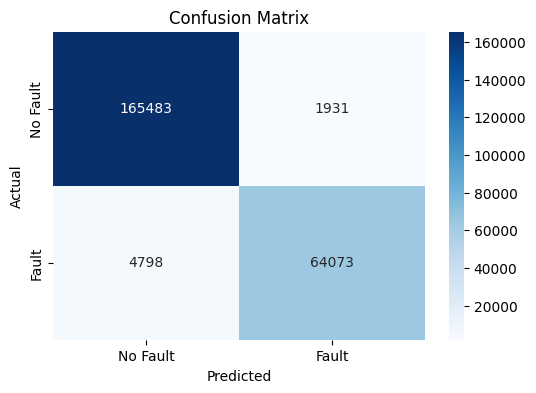

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
#  Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fault', 'Fault'], yticklabels=['No Fault', 'Fault'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [74]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    167414
           1       0.97      0.93      0.95     68871

    accuracy                           0.97    236285
   macro avg       0.97      0.96      0.97    236285
weighted avg       0.97      0.97      0.97    236285

Confusion Matrix:
[[165483   1931]
 [  4798  64073]]
